# Football Player Performance Analysis
Our project aims to predict a football player's overall rating based on their skill attributes and physical characteristics. By analyzing these metrics, we can identify which attributes are most predictive of a player’s performance. This project could offer valuable insights for football clubs and scouts to identify promising players based on skills, helping streamline recruitment and training strategies.
The analysis will also be useful for fans and fantasy football participants who want to better understand player capabilities, providing a unique perspective on player metrics beyond popular statistics.


In [ ]:
# All Imports Here:
from google.colab import drive
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## Part 1: Data Wrangling

### Loading relevant tables into dataframes

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

db_path = '/content/drive/MyDrive/database.sqlite'

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Load data from a table into a DataFrame
player_attributes = 'Player_Attributes'
player = 'Player'
player_attributes_df = pd.read_sql_query(f"SELECT * FROM {player_attributes}", conn)
player_df = pd.read_sql_query(f"SELECT * FROM {player}", conn)

# Close the connection
conn.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Display the Player
player_df.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [ ]:
# Display the Player_Attributes
player_attributes_df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


### Merging table and data wrangling

In [ ]:
from datetime import datetime

# Drop missing data
player_df = player_df.dropna()
player_attributes_df = player_attributes_df.dropna()

# Add player's age (current year - year of birth)
player_df['age'] = player_df['birthday'].apply(lambda x: datetime.now().year - datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year)

# Merge DataFrames on player_api_id
player_processed_df = pd.merge(player_df, player_attributes_df, on='player_api_id')

# Drop irrelevant columns
columns_to_drop = ['id_x', 'id_y', 'date', 'player_name', 'birthday', 'player_fifa_api_id_x', 'player_fifa_api_id_y', 'player_api_id']
player_processed_df = player_processed_df.drop(columns=columns_to_drop, errors='ignore')

## Now we need to encode 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate'
# Encode 'preferred_foot' as binary
player_processed_df['preferred_foot'] = player_processed_df['preferred_foot'].map({'right': 1, 'left': 0})

# Clean invalid values in 'attacking_work_rate' and 'defensive_work_rate'
valid_work_rate = ['high', 'medium', 'low']

# Replace invalid values with NaN and drop rows with NaN
player_processed_df['attacking_work_rate'] = player_processed_df['attacking_work_rate'].apply(lambda x: x if x in valid_work_rate else None)
player_processed_df['defensive_work_rate'] = player_processed_df['defensive_work_rate'].apply(lambda x: x if x in valid_work_rate else None)

# Drop rows with invalid or missing values in 'attacking_work_rate' and 'defensive_work_rate'
player_processed_df = player_processed_df.dropna(subset=['attacking_work_rate', 'defensive_work_rate'])

# Encode 'attacking_work_rate' and 'defensive_work_rate' as ordinal values
work_rate_mapping = {'low': 0, 'medium': 1, 'high': 2}
player_processed_df['attacking_work_rate'] = player_processed_df['attacking_work_rate'].map(work_rate_mapping)
player_processed_df['defensive_work_rate'] = player_processed_df['defensive_work_rate'].map(work_rate_mapping)

# Verify the processed data
player_processed_df

,height,weight,age,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,182.88,187,32,67.0,71.0,1,1,1,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,182.88,187,32,67.0,71.0,1,1,1,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,182.88,187,32,62.0,66.0,1,1,1,49.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,182.88,187,32,61.0,65.0,1,1,1,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,182.88,187,32,61.0,65.0,1,1,1,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180349,180.34,176,42,83.0,85.0,1,1,0,84.0,77.0,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
180350,180.34,176,42,78.0,80.0,1,1,0,74.0,76.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
180351,180.34,176,42,77.0,80.0,1,1,0,74.0,71.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
180352,180.34,176,42,78.0,81.0,1,1,0,74.0,64.0,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


We can see that after preprocessing, we have over 170k rows of data, satisfying our project requirement

## Part 2: EDA

### Distribution of Overall Ratings

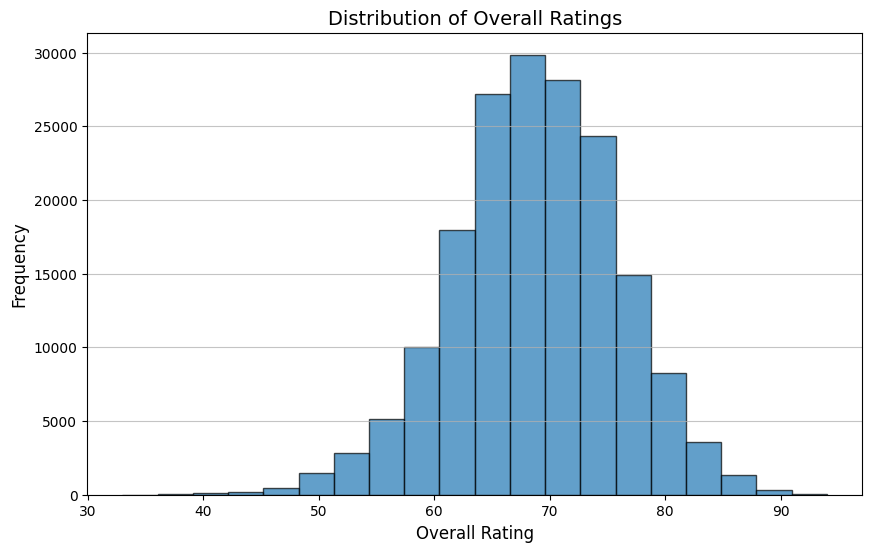

In [ ]:
plt.figure(figsize=(10, 6))
player_processed_df['overall_rating'].plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Overall Ratings', fontsize=14)
plt.xlabel('Overall Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

 The ratings exhibit a normal distribution, with the majority of players clustered between 60 and 75. The peak frequency lies around 70, indicating that most players in the dataset are of average skill level. Few players have ratings below 50 or above 85, suggesting that exceptionally low or high performers are rare. This finding aligns with the general assumption that players' skill levels tend to center around a typical range, with outliers being less common.

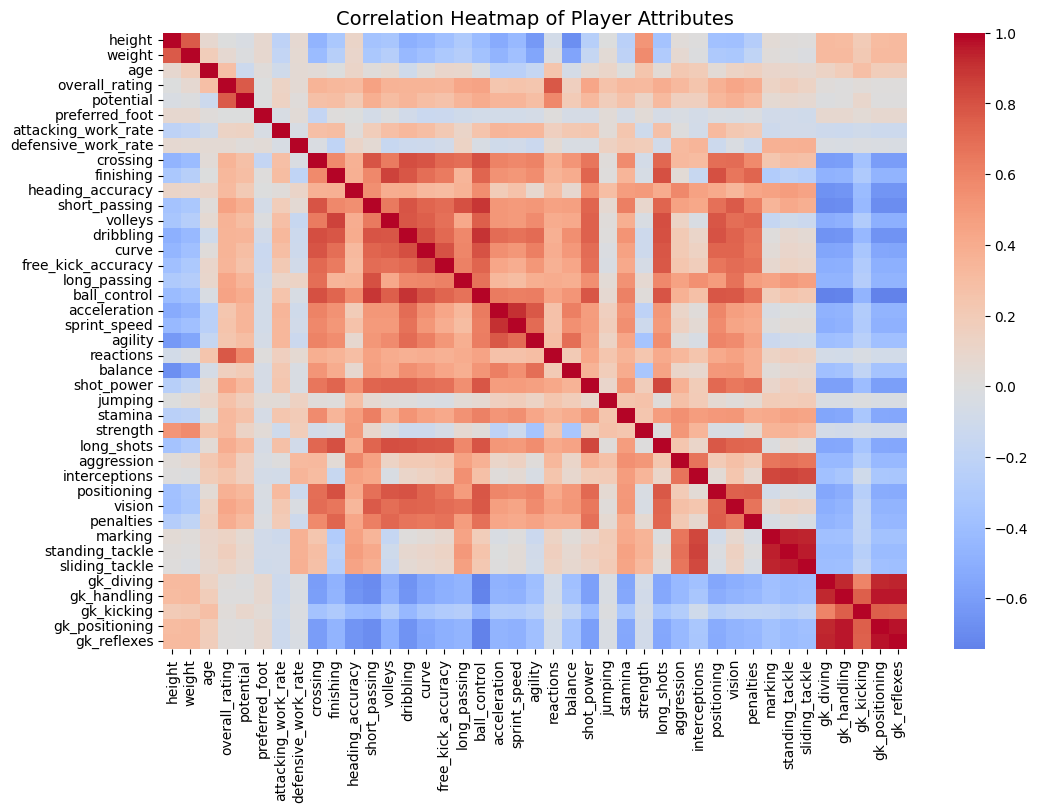

In [ ]:
import seaborn as sns

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = player_processed_df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, cbar=True)
plt.title('Correlation Heatmap of Player Attributes', fontsize=14)
plt.show()

**Strong Positive Correlation Between Ratings and Skills:** Attributes like reactions show strong positive correlations with overall_rating, indicating their importance in determining player performance.

**Goalkeeping Attributes Are Clustered:** Attributes like gk_diving, gk_handling, and gk_positioning are highly correlated with each other but show little correlation with field player attributes, suggesting a distinct skill set for goalkeepers.

**Age & preferred foot Have Limited Impact:** Physical attributes like age and preferred foot show weak correlations with most skill-related attributes and overall rating, indicating that these are less critical in assessing player performance.

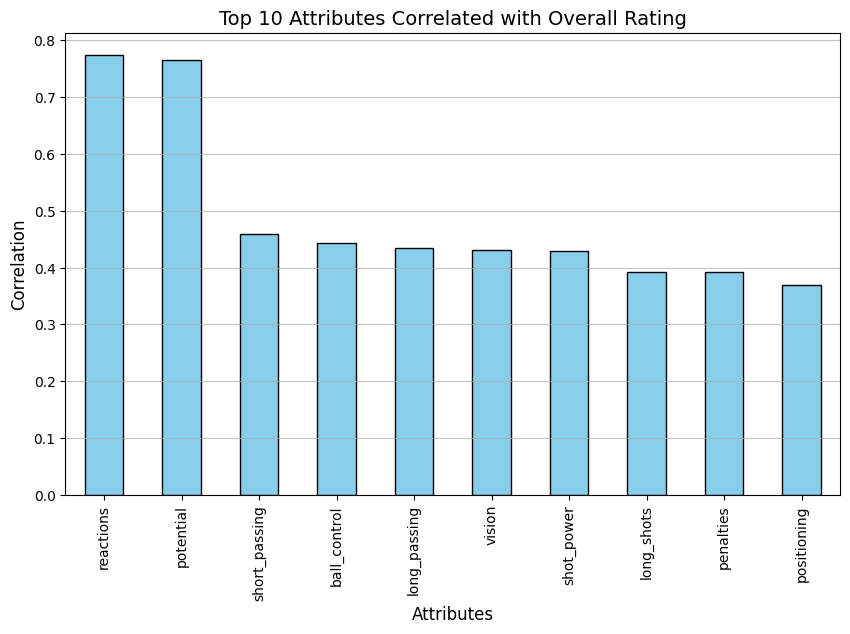

In [ ]:
# Identify the top 10 attributes correlated with overall rating
correlation_with_overall = correlation_matrix['overall_rating'].sort_values(ascending=False)
top_10_attributes = correlation_with_overall[1:11]  # Exclude self-correlation

# Bar plot for top 10 correlations
top_10_attributes.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Top 10 Attributes Correlated with Overall Rating', fontsize=14)
plt.ylabel('Correlation', fontsize=12)
plt.xlabel('Attributes', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

## Part 3: Baseline Model - Linear Regression

### Building the model and evaluate performance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
# Exclude the 'overall_rating' (target) and 'potential' (irrelevant)
X = player_processed_df.drop(columns=['overall_rating', 'potential'])
y = player_processed_df['overall_rating']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 10.473065037968446
R-squared (R2): 0.7869887958512742


### Hypotheis Test
**Null Hypothesis (H₀):** The overall_rating is independent of all the attributes; any observed relationship is due to random chance.

**Warning: do not rerun this cell, it takes 10+ minutes to finish**

In [ ]:
import numpy as np

# Permutation test
n_permutations = 1000
permuted_r2s = []

for _ in range(n_permutations):
    # Shuffle the target variable (overall_rating)
    y_permuted = np.random.permutation(y)

    # Fit the model with shuffled target
    model.fit(X, y_permuted)

    # Compute R^2 for the shuffled data
    permuted_r2s.append(r2_score(y_permuted, model.predict(X)))

# Compute p-value
permuted_r2s = np.array(permuted_r2s)
p_value = np.mean(permuted_r2s >= r2)

print("Observed R^2:", r2)
print("P-value from permutation test:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Attributes significantly explain overall_rating.")
else:
    print("Fail to reject the null hypothesis: Attributes do not significantly explain overall_rating.")


Observed R^2: 0.7869887958512742
P-value from permutation test: 0.0
Reject the null hypothesis: Attributes significantly explain overall_rating.


## Part 4: Random Forest Model - Predict 'overall_rating'

### Baseline RF Model

In [ ]:
# Basic Data Preparation
# Remove goalkeeper features as they're specialized skills
target = 'overall_rating'
gk_features = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
features = [col for col in player_processed_df.columns if col not in gk_features + [target]]

X = player_processed_df[features]
y = player_processed_df[target]

# Split the data consistently for fair comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline Random Forest Model
def train_baseline_model():
    print("\n=== Baseline Random Forest Model ===")

    # Train basic random forest
    rf_baseline = RandomForestRegressor(random_state=42)
    rf_baseline.fit(X_train_scaled, y_train)

    # Make predictions
    baseline_pred = rf_baseline.predict(X_test_scaled)

    # Calculate metrics
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
    baseline_r2 = r2_score(y_test, baseline_pred)
    baseline_mae = mean_absolute_error(y_test, baseline_pred)

    print(f"Baseline Model Performance:")
    print(f"RMSE: {baseline_rmse:.2f}")
    print(f"R2 Score: {baseline_r2:.2f}")
    print(f"MAE: {baseline_mae:.2f}")

    return {'rmse': baseline_rmse, 'r2': baseline_r2, 'mae': baseline_mae}

baseline_scores = train_baseline_model()


=== Baseline Random Forest Model ===
Baseline Model Performance:
RMSE: 1.01
R2 Score: 0.98
MAE: 0.54


### Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning of Random Forest
def train_tuned_rf():
    print("\n=== Tuned Random Forest Model ===")

    # Define parameter grid for tuning
    param_dist = {
        'n_estimators': [50, 100, 120],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt'],
        'bootstrap': [True]
    }

    # Initialize RandomizedSearchCV
    rf_random = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=2,
        scoring='neg_root_mean_squared_error'
    )

    # Fit the random search model
    rf_random.fit(X_train_scaled, y_train)

    # Make predictions with best model
    tuned_pred = rf_random.predict(X_test_scaled)

    # Calculate metrics
    tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_pred))
    tuned_r2 = r2_score(y_test, tuned_pred)
    tuned_mae = mean_absolute_error(y_test, tuned_pred)

    print(f"\nTuned Model Performance:")
    print(f"RMSE: {tuned_rmse:.2f}")
    print(f"R2 Score: {tuned_r2:.2f}")
    print(f"MAE: {tuned_mae:.2f}")
    print("Best Parameters:", rf_random.best_params_)

    return {'rmse': tuned_rmse, 'r2': tuned_r2, 'mae': tuned_mae, 'best_params': rf_random.best_params_}

tuned_scores = train_tuned_rf()


=== Tuned Random Forest Model ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Tuned Model Performance:
RMSE: 0.97
R2 Score: 0.98
MAE: 0.56
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


### PCA Analysis

In [ ]:
# Step 1: Initial PCA fitting
print("\n=== PCA with Tuned Random Forest Model ===")

# Determine optimal number of components
pca = PCA()
pca.fit(X_train_scaled)

# Find number of components for 95% variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

# Step 2: Create and fit pipeline with PCA and tuned RF
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('rf', RandomForestRegressor(**tuned_scores['best_params'], random_state=42))
])

pipeline.fit(X_train_scaled, y_train)

# Step 3: Make predictions and calculate metrics
pca_pred = pipeline.predict(X_test_scaled)
pca_rmse = np.sqrt(mean_squared_error(y_test, pca_pred))
pca_r2 = r2_score(y_test, pca_pred)
pca_mae = mean_absolute_error(y_test, pca_pred)

print(f"\nPCA Model Performance:")
print(f"RMSE: {pca_rmse:.2f}")
print(f"R2 Score: {pca_r2:.2f}")
print(f"MAE: {pca_mae:.2f}")


=== PCA with Tuned Random Forest Model ===
Number of components needed for 95% variance: 22

PCA Model Performance:
RMSE: 1.37
R2 Score: 0.96
MAE: 0.88



Variance Explained by Components:
Component  1:  39.23% of variance
Cumulative :  39.23%
Component  2:  16.44% of variance
Cumulative :  55.68%
Component  3:   7.92% of variance
Cumulative :  63.59%
Component  4:   4.88% of variance
Cumulative :  68.48%
Component  5:   3.54% of variance
Cumulative :  72.01%
Component  6:   3.14% of variance
Cumulative :  75.16%
Component  7:   2.86% of variance
Cumulative :  78.02%
Component  8:   2.53% of variance
Cumulative :  80.55%
Component  9:   2.17% of variance
Cumulative :  82.72%
Component 10:   1.76% of variance
Cumulative :  84.48%
Component 11:   1.39% of variance
Cumulative :  85.87%
Component 12:   1.26% of variance
Cumulative :  87.13%
Component 13:   1.16% of variance
Cumulative :  88.29%
Component 14:   1.08% of variance
Cumulative :  89.38%
Component 15:   0.99% of variance
Cumulative :  90.37%
Component 16:   0.89% of variance
Cumulative :  91.26%
Component 17:   0.83% of variance
Cumulative :  92.09%
Component 18:   0.78% of varia

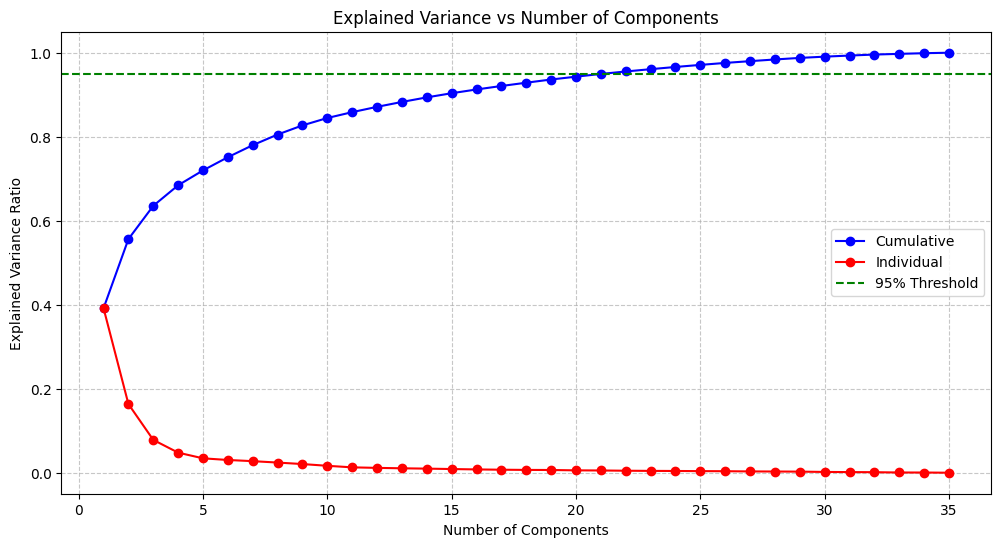


=== Component Composition Analysis ===

Analyzing 22 components that explain 95% of variance:

Component 1 Major Contributors:
ball_control        :    0.253
dribbling           :    0.247
short_passing       :    0.238
long_shots          :    0.234
crossing            :    0.234


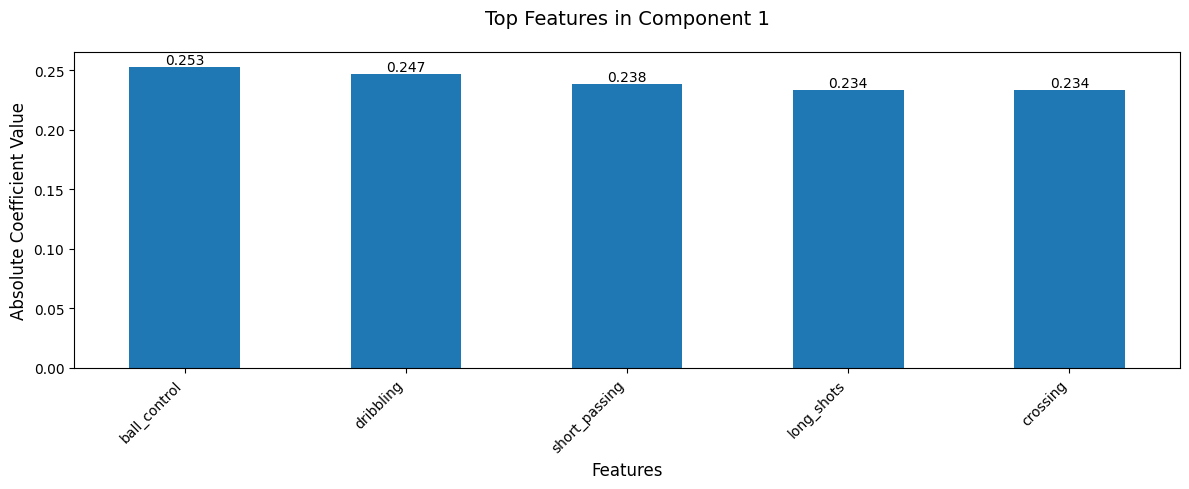


Component 2 Major Contributors:
marking             :    0.372
standing_tackle     :    0.371
sliding_tackle      :    0.363
interceptions       :    0.347
aggression          :    0.307


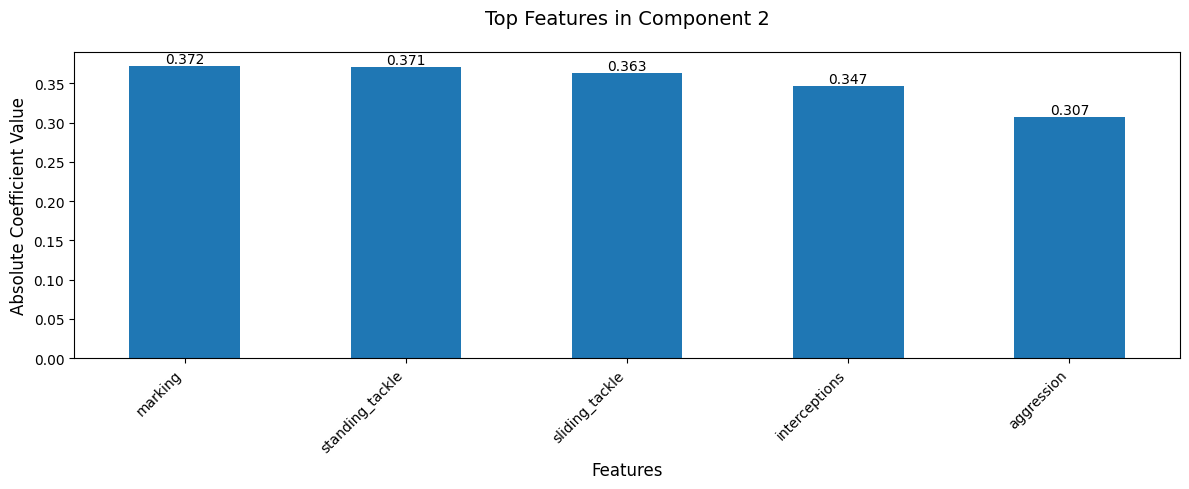


Component 3 Major Contributors:
weight              :    0.385
height              :    0.352
strength            :    0.335
balance             :    0.267
finishing           :    0.210


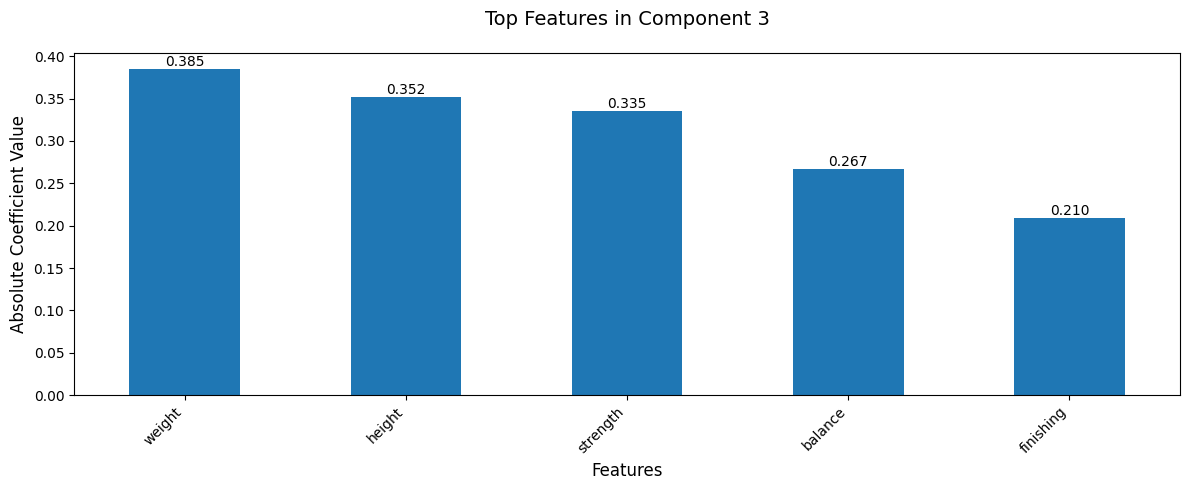


Component 4 Major Contributors:
jumping             :    0.453
sprint_speed        :    0.354
acceleration        :    0.311
potential           :    0.307
free_kick_accuracy  :    0.235


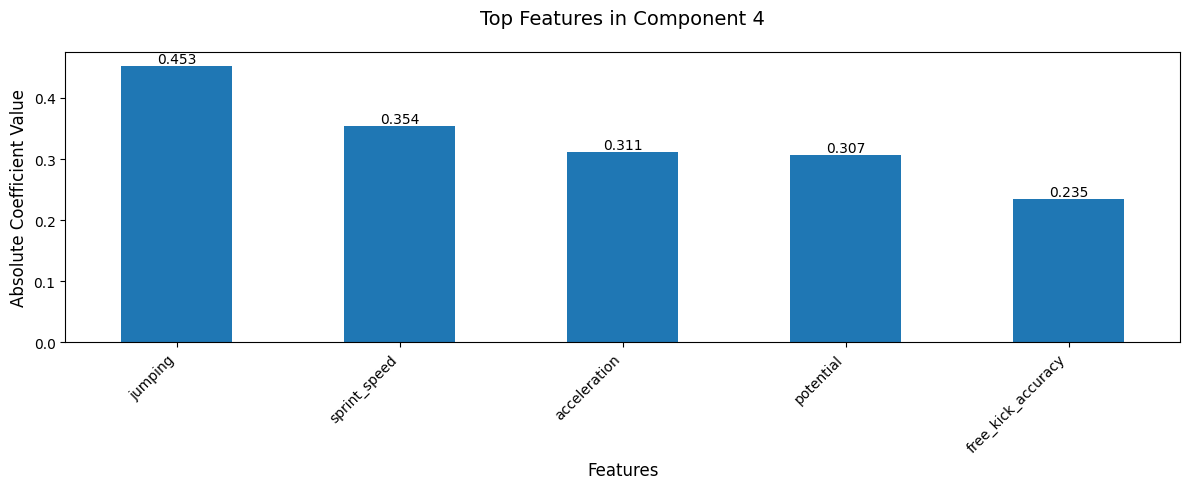


Component 5 Major Contributors:
age                 :    0.558
reactions           :    0.417
jumping             :    0.314
balance             :    0.230
heading_accuracy    :    0.215


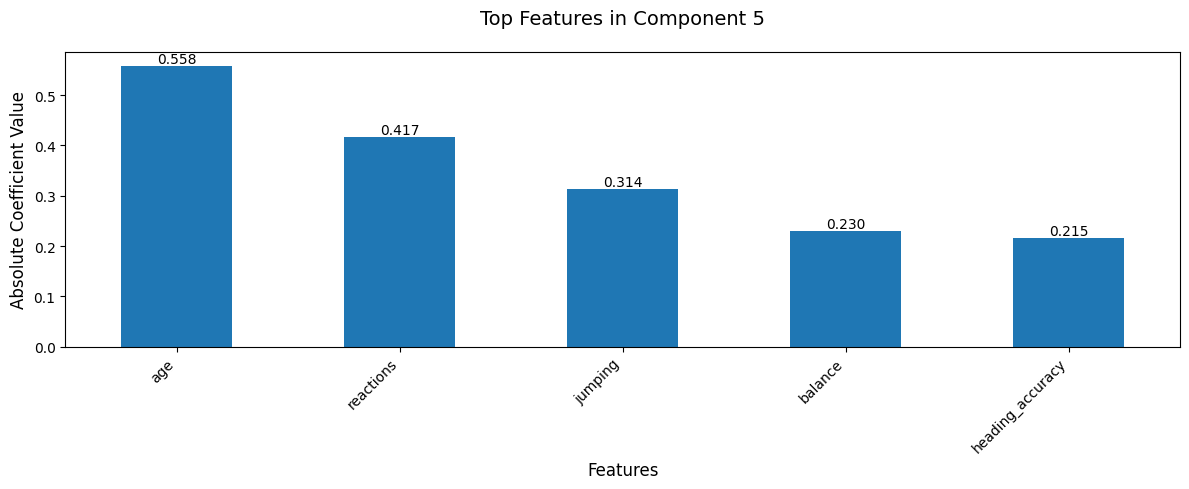


=== Correlation Analysis ===


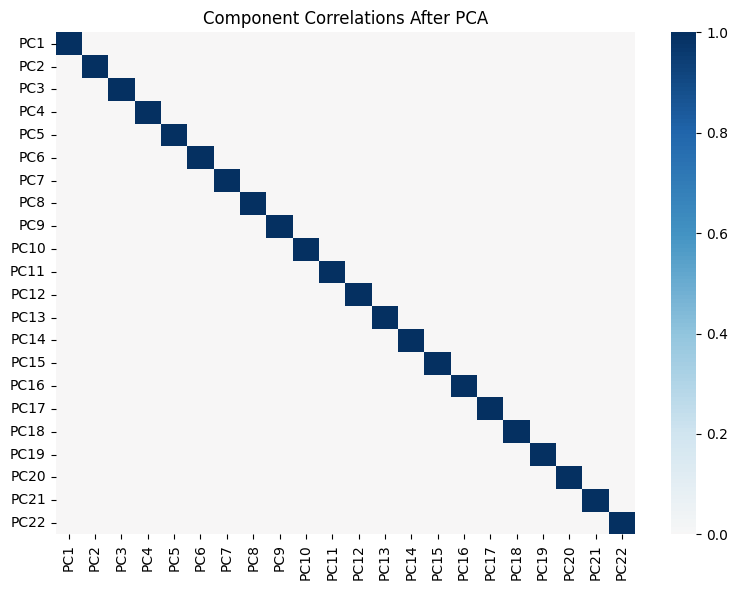


=== Dimensionality Reduction Summary ===
Original features: 35
Components kept: 22
Feature reduction: 13 features removed
Information retained: 95% of original variance


In [ ]:
# Step 4: Analyze and visualize variance explained
print("\nVariance Explained by Components:")
for i, var in enumerate(explained_variance_ratio):
    print(f"Component {i+1:2d}: {var*100:6.2f}% of variance")
    print(f"Cumulative : {cumulative_variance[i]*100:6.2f}%")
    if cumulative_variance[i] > 0.99:
        break

# Create variance plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1),
         cumulative_variance, 'bo-', label='Cumulative')
plt.plot(range(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio, 'ro-', label='Individual')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Step 5: Analyze component composition
print("\n=== Component Composition Analysis ===")
components_df = pd.DataFrame(
    pca.components_,
    columns=X_train.columns
)

# Show composition of significant components
print(f"\nAnalyzing {n_components} components that explain 95% of variance:")

# Loop through components and show top features
for i in range(5):
    weights = pd.Series(
        abs(components_df.iloc[i]),
        index=X_train.columns
    )
    top_features = weights.nlargest(5)

    print(f"\nComponent {i+1} Major Contributors:")
    for feat, weight in top_features.items():
        print(f"{feat:20s}: {weight:8.3f}")

    # Create bar plot for this component
    plt.figure(figsize=(12, 5))
    ax = top_features.plot(kind='bar')
    plt.title(f'Top Features in Component {i+1}', fontsize=14, pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Absolute Coefficient Value', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for i, v in enumerate(top_features):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Step 6: Correlation Analysis
print("\n=== Correlation Analysis ===")

# After PCA correlations
X_pca = pipeline.named_steps['pca'].transform(X_train_scaled)
pca_data = pd.DataFrame(
    X_pca[:, :n_components],
    columns=[f'PC{i+1}' for i in range(n_components)]
)
plt.figure(figsize=(8, 6))
sns.heatmap(pca_data.corr(), cmap='RdBu', center=0)
plt.title('Component Correlations After PCA')
plt.tight_layout()
plt.show()

# Step 7: Print dimensionality reduction summary
print("\n=== Dimensionality Reduction Summary ===")
print(f"Original features: {X_train.shape[1]}")
print(f"Components kept: {n_components}")
print(f"Feature reduction: {X_train.shape[1] - n_components} features removed")
print(f"Information retained: 95% of original variance")

### Model Improvements

In [ ]:
print("\n=== Model Improvements ===")
print("Tuning Improvements:")
r2_improvement_from_linear = ((tuned_scores['r2'] - r2) / r2) * 100
tuning_rmse_improvement = ((baseline_scores['rmse'] - tuned_scores['rmse']) / baseline_scores['rmse']) * 100
tuning_r2_improvement = ((tuned_scores['r2'] - baseline_scores['r2']) / baseline_scores['r2']) * 100
print(f"RMSE Improvement by Tuning: {tuning_rmse_improvement:.2f}%")
print(f"R2 Score Improvement from Linear Regression: {r2_improvement_from_linear:.2f}%")
print(f"R2 Score Improvement by Tuning: {tuning_r2_improvement:.2f}%")

print("\nPCA Improvements (compared to tuned model):")
pca_rmse_improvement = ((tuned_scores['rmse'] - pca_rmse) / tuned_scores['rmse']) * 100
pca_r2_improvement = ((pca_r2 - tuned_scores['r2']) / tuned_scores['r2']) * 100
print(f"RMSE Improvement after PCA: {pca_rmse_improvement:.2f}%")
print(f"R2 Score Improvement after PCA: {pca_r2_improvement:.2f}%")

reflection = """
Reflections:
While we might be able to combine some attributes (like speed and acceleration) into a single "mobility" score, other attributes might be uniquely important on their own.

In soccer, being excellent at one specific skill can be more valuable than being average at multiple skills.

The technical reasons for the decreased performance include:

1. Information Loss Despite 95% Variance Retention
While we kept 95% of the statistical variance, the 5% we lost might contain crucial subtle differences between players.
For example, the difference between an 85 and 90 shooting rating might be more meaningful than the difference between 60 and 70.

2. Feature Interactions
Soccer player attributes often have non-linear relationships that PCA, being a linear transformation, might not capture well.

This experience teaches us an important lesson about dimensionality reduction:
sometimes maintaining the original feature space is better for prediction, even if it means dealing with more dimensions.
In domains like sports, where individual skills matter greatly and combine in complex ways, direct feature use might be more effective than dimensional reduction.
"""
print(reflection)


=== Model Improvements ===
Tuning Improvements:
RMSE Improvement by Tuning: 3.96%
R2 Score Improvement from Linear Regression: 24.66%
R2 Score Improvement by Tuning: 0.16%

PCA Improvements (compared to tuned model):
RMSE Improvement after PCA: -41.99%
R2 Score Improvement after PCA: -1.96%

Reflections:
While we might be able to combine some attributes (like speed and acceleration) into a single "mobility" score, other attributes might be uniquely important on their own.

In soccer, being excellent at one specific skill can be more valuable than being average at multiple skills.

The technical reasons for the decreased performance include:

1. Information Loss Despite 95% Variance Retention
While we kept 95% of the statistical variance, the 5% we lost might contain crucial subtle differences between players.
For example, the difference between an 85 and 90 shooting rating might be more meaningful than the difference between 60 and 70.

2. Feature Interactions
Soccer player attributes

## Part 5: XGBoost - Predict 'overall_rating' & Analysis with SHAP


Number of features: 39
Sample features: ['height', 'weight', 'age', 'preferred_foot', 'attacking_work_rate']
Training samples: 140928
Testing samples: 35233

Training XGBoost Regressor...
[0]	validation_0-rmse:6.74207
[1]	validation_0-rmse:6.48892
[2]	validation_0-rmse:6.23480
[3]	validation_0-rmse:5.99287
[4]	validation_0-rmse:5.76695
[5]	validation_0-rmse:5.55685
[6]	validation_0-rmse:5.35183
[7]	validation_0-rmse:5.16036
[8]	validation_0-rmse:4.98101
[9]	validation_0-rmse:4.80089
[10]	validation_0-rmse:4.63575
[11]	validation_0-rmse:4.48042
[12]	validation_0-rmse:4.33095
[13]	validation_0-rmse:4.18304
[14]	validation_0-rmse:4.05198
[15]	validation_0-rmse:3.92841
[16]	validation_0-rmse:3.80883
[17]	validation_0-rmse:3.69485
[18]	validation_0-rmse:3.58775
[19]	validation_0-rmse:3.48660
[20]	validation_0-rmse:3.39203
[21]	validation_0-rmse:3.30099
[22]	validation_0-rmse:3.21587
[23]	validation_0-rmse:3.13474
[24]	validation_0-rmse:3.05155
[25]	validation_0-rmse:2.97901
[26]	validation_

100%|===================| 35079/35233 [03:32<00:00]       


Generating SHAP Summary Plot...


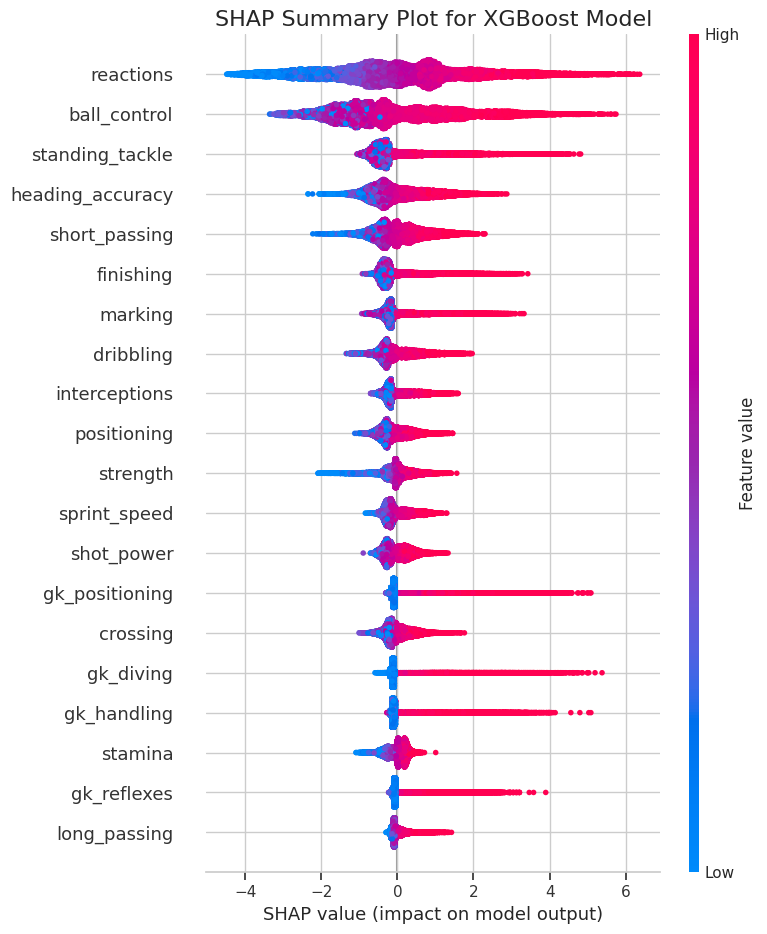

Generating SHAP Feature Importance Bar Plot...


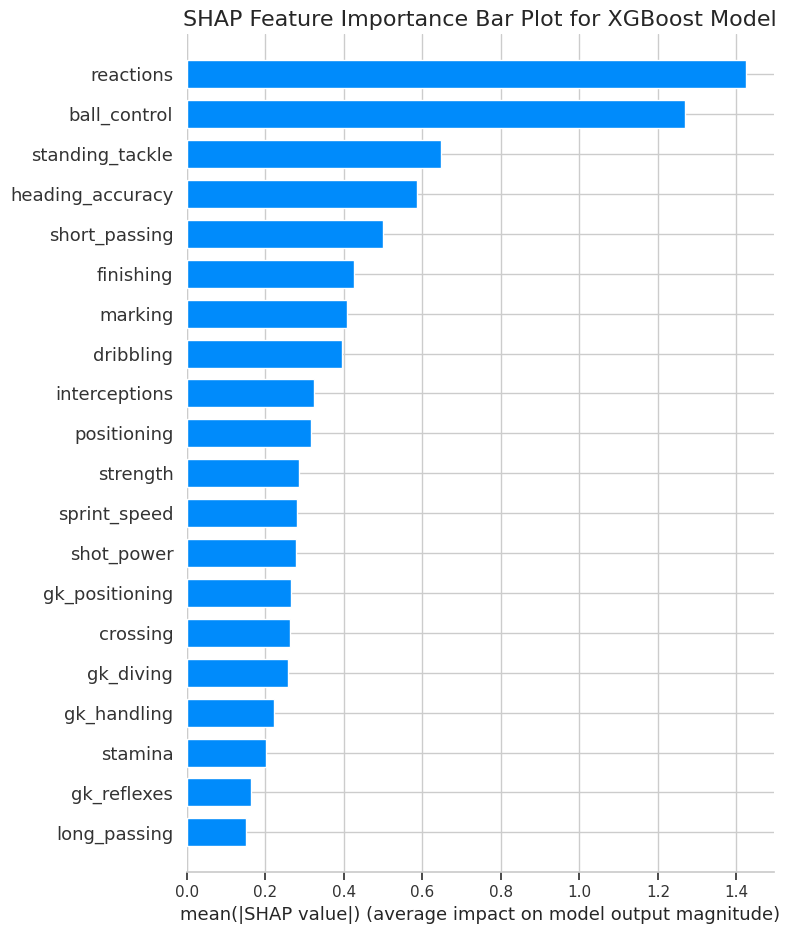

Generating SHAP Dependence Plot for top feature: reactions...


<Figure size 1000x600 with 0 Axes>

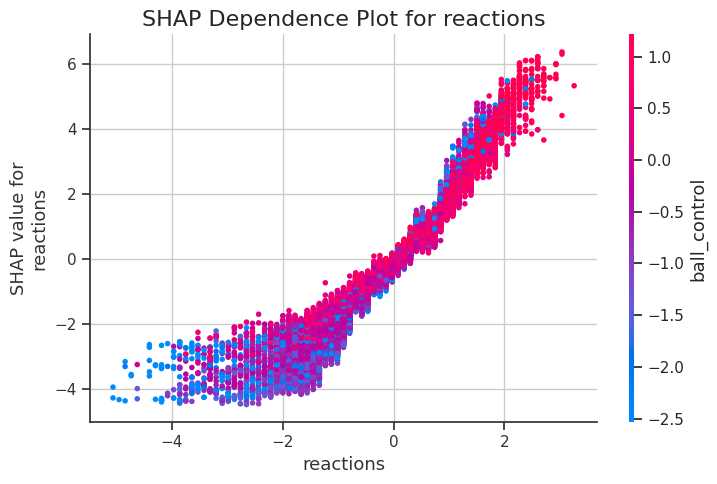

Generating SHAP Force Plot for instance index: 0...


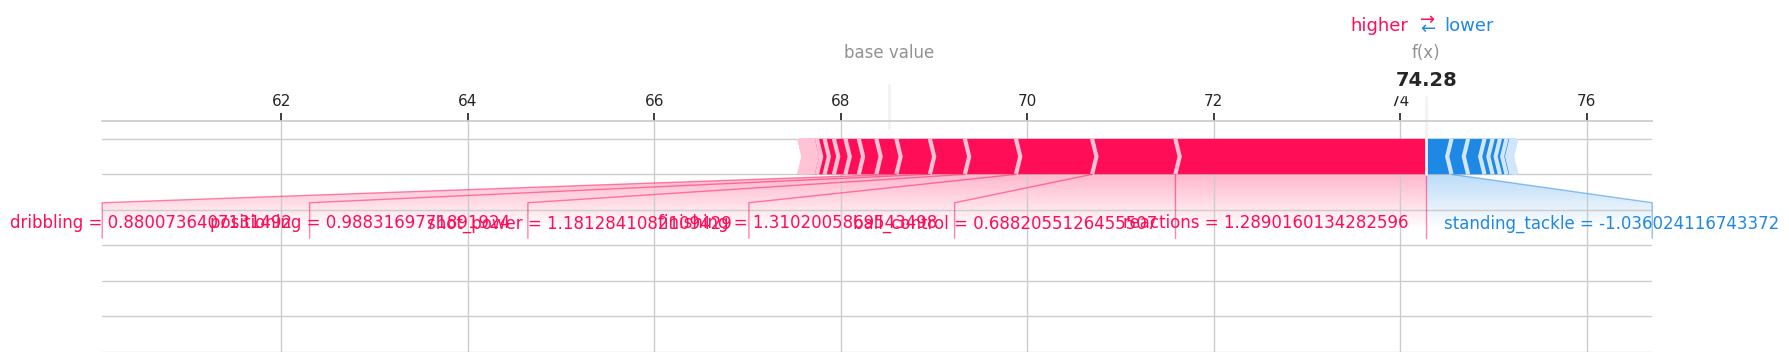

In [ ]:
import xgboost as xgb
import shap

sns.set(style='whitegrid')

# 2. Define Features and Target
# Assuming 'player_processed_df' is your preprocessed DataFrame
# Replace 'player_processed_df' with your actual DataFrame variable if different

# Check if 'player_processed_df' exists
try:
    player_processed_df
except NameError:
    raise Exception("DataFrame 'player_processed_df' is not defined. Please ensure your data is loaded and preprocessed.")

# Define target variable
target = 'overall_rating'

# Define feature set by excluding the target and any irrelevant columns
# Adjust 'columns_to_exclude' based on your dataset
columns_to_exclude = ['potential']  # Add other columns to exclude if necessary
features = [col for col in player_processed_df.columns if col not in columns_to_exclude + [target]]

X = player_processed_df[features]
y = player_processed_df[target]

print(f"Number of features: {X.shape[1]}")
print(f"Sample features: {features[:5]}")  # Display first 5 feature names

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Train XGBoost Model
# Initialize XGBoost Regressor with hyperparameters
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("\nTraining XGBoost Regressor...")
xgb_reg.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=True)

# 6. Evaluate the Model
# Make predictions on the test set
y_pred_xgb = xgb_reg.predict(X_test_scaled)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print("\n=== XGBoost Model Performance ===")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R²: {r2_xgb:.2f}")

# 7. Apply SHAP for Explainability
# Initialize SHAP Explainer for XGBoost
print("\nApplying SHAP for model explainability...")
explainer = shap.Explainer(xgb_reg, X_train_scaled)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_scaled)

# 8. Visualize SHAP Results

# a. SHAP Summary Plot
print("\nGenerating SHAP Summary Plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=features, show=False)
plt.title('SHAP Summary Plot for XGBoost Model', fontsize=16)
plt.tight_layout()
plt.show()

# b. SHAP Feature Importance (Bar Plot)
print("Generating SHAP Feature Importance Bar Plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, feature_names=features, plot_type='bar', show=False)
plt.title('SHAP Feature Importance Bar Plot for XGBoost Model', fontsize=16)
plt.tight_layout()
plt.show()

# c. SHAP Dependence Plot for Top Feature
# Identify the top feature based on mean absolute SHAP value
mean_shap = np.abs(shap_values.values).mean(axis=0)
top_feature = features[np.argmax(mean_shap)]

print(f"Generating SHAP Dependence Plot for top feature: {top_feature}...")
plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature, shap_values.values, X_test_scaled, feature_names=features, show=False)
plt.title(f'SHAP Dependence Plot for {top_feature}', fontsize=16)
plt.tight_layout()
plt.show()

# d. SHAP Force Plot for a Single Prediction (Optional)
# Select an instance to visualize
instance_idx = 0  # Change as needed
print(f"Generating SHAP Force Plot for instance index: {instance_idx}...")
shap.force_plot(explainer.expected_value, shap_values.values[instance_idx], X_test_scaled[instance_idx], feature_names=features, matplotlib=True)
plt.show()



## Part 6: Neural Network - Predict 'overall_rating'


### Baseline NN Model


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2332.7744 - mae: 41.1210 - val_loss: 60.5946 - val_mae: 6.1345
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 140.8450 - mae: 9.4971 - val_loss: 26.7732 - val_mae: 4.0571
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 102.3915 - mae: 8.0870 - val_loss: 17.9148 - val_mae: 3.4129
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 88.8422 - mae: 7.5252 - val_loss: 11.2309 - val_mae: 2.5974
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 82.5501 - mae: 7.2429 - val_loss: 7.6773 - val_mae: 2.1087
Epoch 6/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77.7330 - mae: 6.9989 - val_loss: 9.7518 - val_mae: 2.5371
Epoch 7/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 74.5243 - mae: 6.8744 - val_loss: 5.3735 - val_mae: 1.7619
Epoch 8/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 72.2462 - mae: 6.7589 - val_loss: 4.7201 - val_mae: 1.6216
Epoch 9/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st

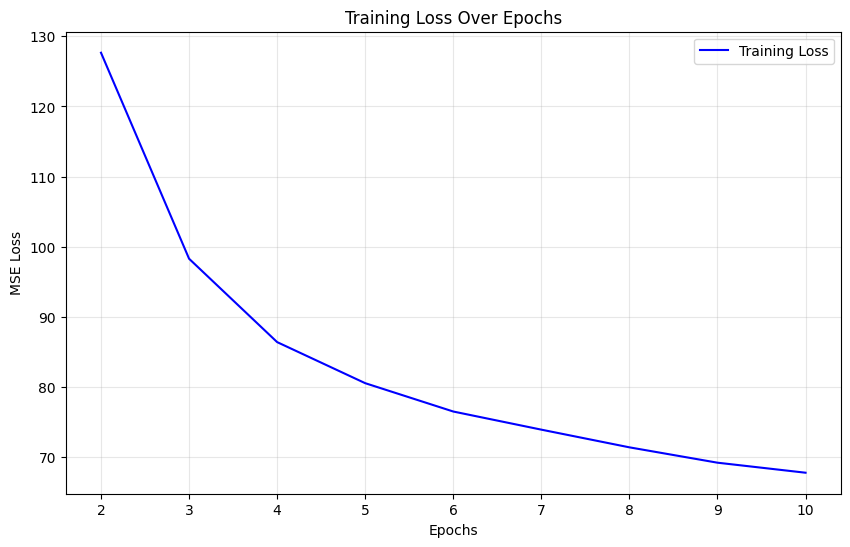

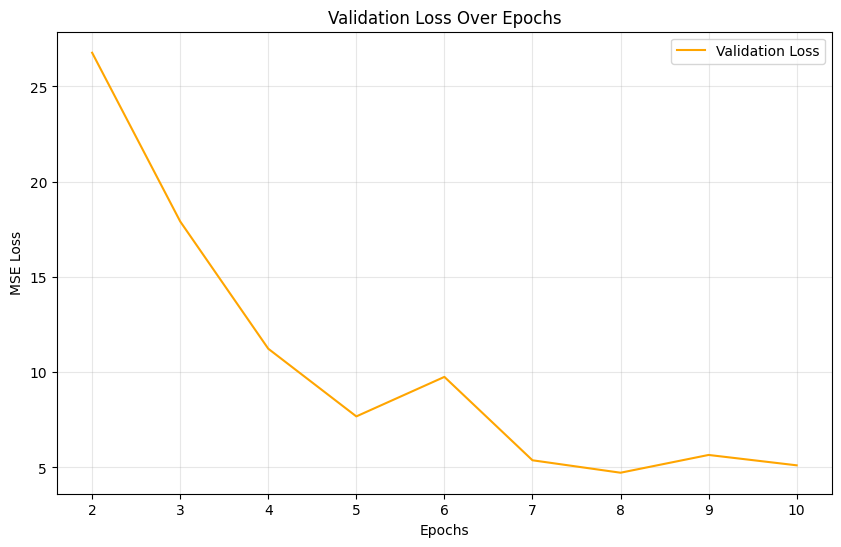

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Basic Data Preparation
# Remove goalkeeper features as they're specialized skills
target = 'overall_rating'
gk_features = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
features = [col for col in player_processed_df.columns if col not in gk_features + [target]]

X = player_processed_df[features]
y = player_processed_df[target]

# Split the data consistently for fair comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assuming you have X_train_scaled, X_test_scaled, y_train, and y_test from previous code:
# X_train_scaled, X_test_scaled: scaled feature sets
# y_train, y_test: target arrays

# Define the architecture of the neural network
def build_model(input_dim):
    model = models.Sequential()
    # Input Layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(rate=0.2))

    # Hidden Layers
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dropout(rate=0.1))

    # Output Layer (Regression)
    model.add(layers.Dense(units=1))  # linear activation is default for last layer in regression

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build the model
input_dim = X_train_scaled.shape[1]
dnn_model = build_model(input_dim)

# Early Stopping to prevent overfitting
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = dnn_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=512,
    callbacks=[early_stopper],
    verbose=1
)

# Evaluate the model on test set
dnn_pred = dnn_model.predict(X_test_scaled).ravel()

mse_nn = mean_squared_error(y_test, dnn_pred)
mae_nn = mean_absolute_error(y_test, dnn_pred)
r2_nn = r2_score(y_test, dnn_pred)
rmse_nn = mse_nn**0.5

print("=== Neural Network Model Performance ===")
print(f"RMSE: {rmse_nn:.2f}")
print(f"MAE: {mae_nn:.2f}")
print(f"R²: {r2_nn:.2f}")

# Plot training history for loss
import matplotlib.pyplot as plt

# Create a range for epochs excluding the first epoch
total_epochs = len(history.history['loss'])
epochs = range(2, total_epochs + 1)  # Start from epoch 2

# Plot Training Loss excluding the first epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['loss'][1:], label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot Validation Loss excluding the first epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['val_loss'][1:], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




### Training NN model after PCA


Original number of features: 39
Reduced number of features after PCA: 22


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                     │ (None, 128)                 │           2,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 2179.3120 - mae: 38.8793 - val_loss: 53.0259 - val_mae: 5.7862
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 131.9044 - mae: 9.1956 - val_loss: 30.0847 - val_mae: 4.3602
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 100.3359 - mae: 8.0055 - val_loss: 17.3973 - val_mae: 3.3036
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 85.0780 - mae: 7.3505 - val_loss: 11.9535 - val_mae: 2.7567
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 76.6159 - mae: 6.9822 - val_loss: 8.3806 - val_mae: 2.3090
Epoch 6/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 69.7534 - mae: 6.6647 - val_loss: 7.2919 - val_mae: 2.1841
Epoch 7/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 66.4729 - mae: 6.4925 - val_loss: 6.0265 - val_mae: 1.9586
Epoch 8/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 63.3093 - mae: 6.3312 - val_loss: 4.8244 - val_mae: 1.6998
Epoch 9/10
221/221 ━━━━━━━━━━━━━━━━━━

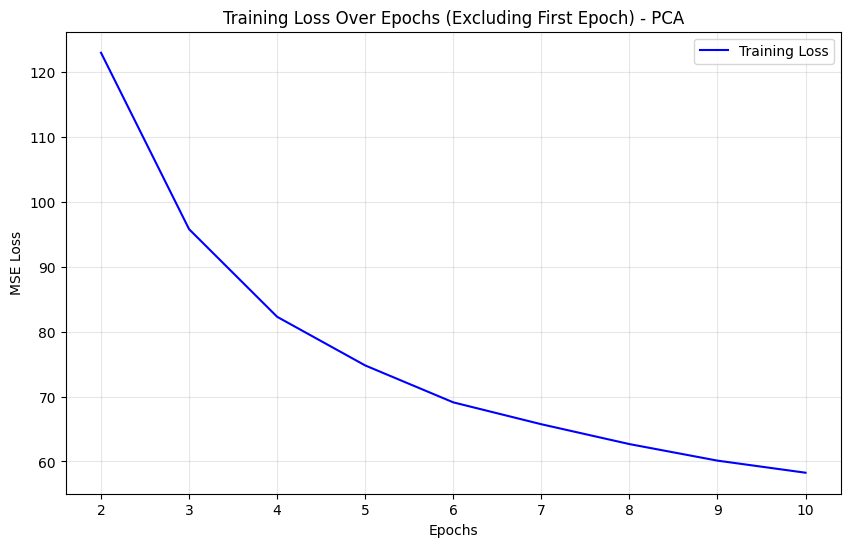

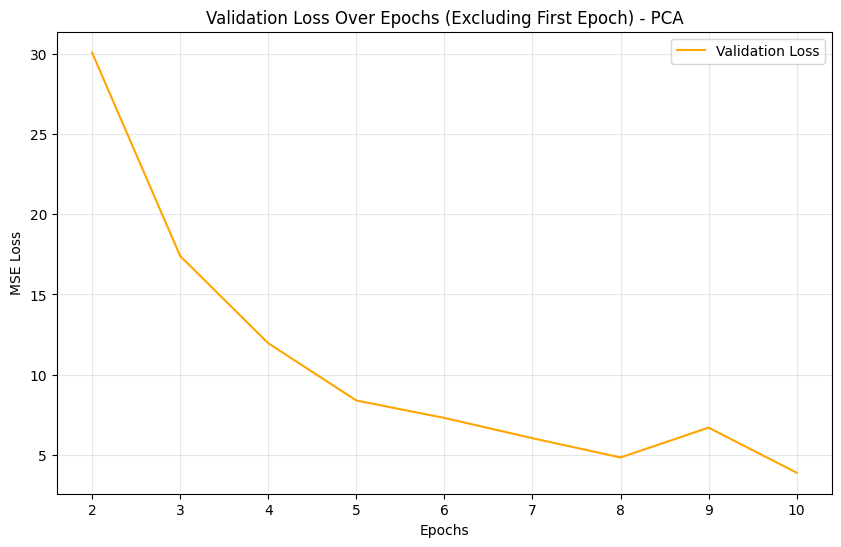

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import tensorflow as tf


# Define target variable
target = 'overall_rating'

# Define feature set by excluding the target and any irrelevant columns
# Adjust 'columns_to_exclude' based on your dataset
columns_to_exclude = ['potential']  # Add other columns to exclude if necessary
features = [col for col in player_processed_df.columns if col not in columns_to_exclude + [target]]

X = player_processed_df[features]
y = player_processed_df[target]

# 4. Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Apply PCA

# Initialize PCA to retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

# 7. Build and Train Neural Network

# Define the architecture of the neural network
def build_pca_model(input_dim):
    model = models.Sequential()
    # Input Layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(rate=0.2))

    # Hidden Layers
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dropout(rate=0.1))

    # Output Layer (Regression)
    model.add(layers.Dense(units=1))  # Linear activation for regression

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build the model
input_dim_pca = X_train_pca.shape[1]
dnn_pca_model = build_pca_model(input_dim_pca)
dnn_pca_model.summary()

# Early Stopping to prevent overfitting
early_stopper_pca = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history_pca = dnn_pca_model.fit(
    X_train_pca,
    y_train,
    validation_split=0.2,        # 20% of training data for validation
    epochs=10,                   # Maximum number of epochs
    batch_size=512,              # Batch size
    callbacks=[early_stopper_pca],
    verbose=1
)

# 8. Evaluate the Model

# Make predictions on the test set
dnn_pca_pred = dnn_pca_model.predict(X_test_pca).ravel()

# Calculate evaluation metrics
mse_pca = mean_squared_error(y_test, dnn_pca_pred)
mae_pca = mean_absolute_error(y_test, dnn_pca_pred)
r2_pca = r2_score(y_test, dnn_pca_pred)
rmse_pca = np.sqrt(mse_pca)

print("\n=== Neural Network with PCA Model Performance ===")
print(f"RMSE: {rmse_pca:.2f}")
print(f"MAE: {mae_pca:.2f}")
print(f"R²: {r2_pca:.2f}")

# 9. Visualize Training and Validation Loss

# Determine the number of epochs trained
total_epochs_pca = len(history_pca.history['loss'])
epochs_pca = range(2, total_epochs_pca + 1)  # Start from epoch 2

# Plot Training Loss excluding the first epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs_pca, history_pca.history['loss'][1:], label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs (Excluding First Epoch) - PCA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot Validation Loss excluding the first epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs_pca, history_pca.history['val_loss'][1:], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Validation Loss Over Epochs (Excluding First Epoch) - PCA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Implications & Future Work
**Implications** this analysis highlights how clubs and scouts could focus on specific attributes, such as reactions, which consistently emerged as a key predictor, to identify promising players. It also reinforces the importance of technical skills like dribbling and ball_control for overall performance.

**Challenges**
Data Imbalance: The distribution of player ratings is normal, but there are fewer examples of high- and low-performing players. This imbalance could limit the model's ability to predict extreme cases.

**Potential Future Work**
Role-Specific Analysis: Create separate models for different player positions, as the attributes important for goalkeepers, defenders, and strikers may differ significantly.
